<a href="https://colab.research.google.com/github/Loop3D/m2l3_examples/blob/main/inclined%20parallel%20stratigraphy/Synthetic_example_parallel_and_inclined_stratigraphy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In [1]:
# install stuff if running on Colab
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/Loop3D/map2model_cpp.git
    !pip install git+https://github.com/Loop3D/map2loop.git
    !pip install git+https://github.com/Loop3D/LoopStructural.git@v1.5.11
    !pip install git+https://github.com/Loop3D/LoopProjectFile.git@0.0.26
    !pip install lavavu-osmesa==1.8.60
    !pip install meshio
    !pip uninstall gdown -y
    !pip install gdown
    # data files in link below
    !gdown --folder https://drive.google.com/drive/folders/1ZEJvPN4lpGpvoepjGMZgzYPGaY3mT46p
else:
      print('Not running on CoLab, nothing to do')

  Cloning https://github.com/Loop3D/map2model_cpp.git to /tmp/pip-req-build-xwu8gqq8
  Running command git clone --filter=blob:none --quiet https://github.com/Loop3D/map2model_cpp.git /tmp/pip-req-build-xwu8gqq8
  Resolved https://github.com/Loop3D/map2model_cpp.git to commit 4a3e59528e99a0592bd5cc213ee0eaae559b9c8a
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for map2model: filename=map2model-1.2.0-cp310-cp310-linux_x86_64.whl size=4840719 sha256=dba1d8cfc6ec0002f71bea2e19ae47bcda725c338c4e4fed5536ff2d397f144e
  Stored in directory: /tmp/pip-ephem-wheel-cache-wtxj3aay/wheels/8e/be/f7/b722f54fd3a176ede7c9b6ddd5f939abc9e16727b997f903e9
Successfully built map2model
  Cloning https://github.com/Loop3D/map2loop.git to /tmp/pip-req-build-a_zgwmnr
  Running command git clone --filter=blob:none --quiet https://github.com/Loop3D/map2loop.git /tmp/pip-req-build-a_zgwmnr
  Resolved https://github.com/Loop3D/map2loop.git to 

In [2]:
import os
import time
import numpy as np
from osgeo import gdal
import pandas as pd
from datetime import datetime

from map2loop.project import Project
from map2loop.m2l_enums import VerboseLevel

from map2loop.m2l_enums import Datatype
from map2loop.sampler import SamplerSpacing, SamplerDecimator

import LoopStructural
import LoopProjectFile as LPF
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling.input.project_file import LoopProjectfileProcessor as LPFProcessor

In [3]:
bounding_box = {
    "minx": 0,
    "miny": 0,
    "maxx": 10000,
    "maxy": 10000,
    "base": 0,
    "top": -5000,
}

nowtime=datetime.now().isoformat(timespec='minutes')
model_name=nowtime.replace(":","-").replace("T","-")
loop_project_filename = os.path.join(model_name, "local_source.loop3d")

In [4]:
proj = Project(
    geology_filename = './data/lithologies.shp',
    fault_filename = "./data/faults.shp",
    fold_filename = "./data/faults.shp",
    structure_filename = "./data/measurements.shp",
    dtm_filename = './data/DEM.tif',
    config_filename = './data/example.hjson',
    clut_filename = './data/500kibg_colours.csv',
    clut_file_legacy = True,
    verbose_level = VerboseLevel.NONE,
    tmp_path = model_name,
    working_projection = "EPSG:7854",
    bounding_box = bounding_box,
    loop_project_filename = loop_project_filename
)

Unused keys from legacy format ['msc', 'msn', 'mst', 'mtc', 'mscm', 'mcom', 'minf', 'fdipdir_flag', 'deposit_dist']
Datatype FAULT_ORIENTATION is not set and so cannot be loaded



In [5]:
# Set to only take every second orientation observation (0 or 1 means take all observations)
proj.set_sampler(Datatype.STRUCTURE, SamplerDecimator(0))
# proj.set_sampler(Datatype.GEOLOGY, SamplerDecimator(50))

In [6]:
# Or you can run map2loop and pre-specify the stratigraphic column
column = [
    # youngest
    'Litho_A',
    'Litho_B',
    'Litho_C',
    'Litho_D'
    # oldest
]

column
proj.run_all(user_defined_stratigraphic_column=column)

LPFilename = loop_project_filename
projFile = LPF.ProjectFile(LPFilename)
processedData = LPFProcessor(projFile)

Cannot calculate thickness between Litho_C and Litho_D


In [7]:
foliation_params = {
    'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
    'nelements':1e5,  # how many tetras/voxels
    'regularisation':5,
    'solver': 'pyamg'
}

model = LoopStructural.GeologicalModel.from_processor(processedData)
model.update()

  0%|          | 0/1 [00:00<?, ?it/s]


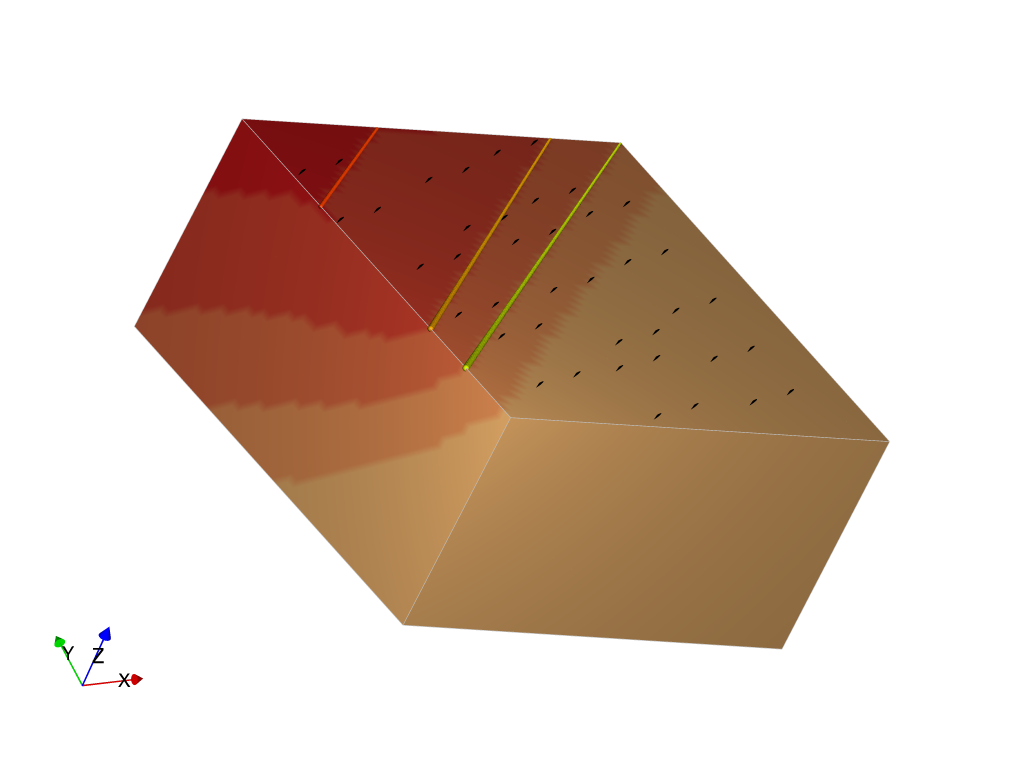

In [8]:
from google.colab import output
output.enable_custom_widget_manager()

from LoopStructural.visualisation import LavaVuModelViewer

view = LavaVuModelViewer(model)

view.add_data(model['sg'])
view.add_model()

view.rotation = [-56.68132781982422, 42.125144958496094, -3.6206510066986084]
view.display()